<a href="https://colab.research.google.com/github/Hardik0175/Graph_Mining/blob/main/Hardik_Sharma_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install python-igraph
!pip install plfit
!pip install networkx

In [ ]:
datadir='/content/gdrive/My Drive/Datasets/'
## for loading dataset from google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [65]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter


In [93]:
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)


In [95]:
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [128]:
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v, mode='out')))]
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graphs
## can also be computed as <k^2>/<k>
def deg_corr_random(G):
    deg = G.degree()
    L = []
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L.extend(w)
    return np.mean(L)

def deg_uncorr(G):
  deg = G.degree()
  k = np.average(deg)
  var = np.var(deg)
  value = (k**2+var)/k
  return value

def deg_corr_random_directed(G, mode='all'):
    deg = G.degree(mode=mode)
    L = []
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v,mode='out')))]
        L.extend(w)
    return np.mean(L)

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


In [176]:
## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

# Problem 1

a. Original Graph

Degree correlation coefficient r: 441.020594941921
Correlation exponent mu:-0.5076879013701244


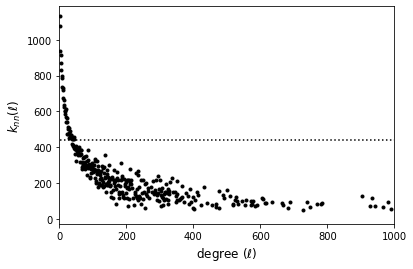

In [130]:
## degree correlation function
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_uncorr(gh)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
mu = corr_exp(gh)
print('Degree correlation coefficient r: ' + str(r))
print('Correlation exponent mu:' + str(mu))

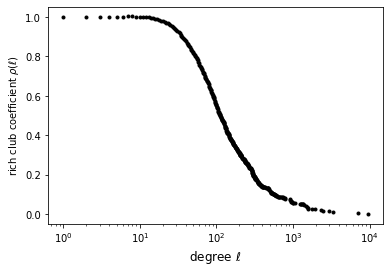

In [131]:
d = list(set(gh.degree()))
rc = []
for i in d:
    rc.append(richClub(gh, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

b. Developer ML

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log




Degree correlation coefficient r: 36.43680146311726
Correlation exponent mu:1.8306636739345343e-308


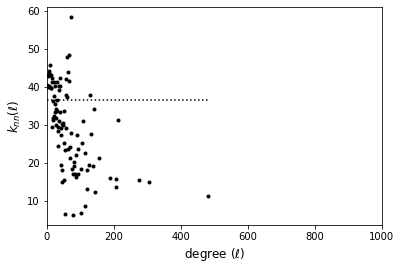

In [137]:
## degree correlation function
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_uncorr(gh_ml)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
mu = corr_exp(gh_ml)
print('\n')
print('Degree correlation coefficient r: ' + str(r))
print('Correlation exponent mu:' + str(mu))

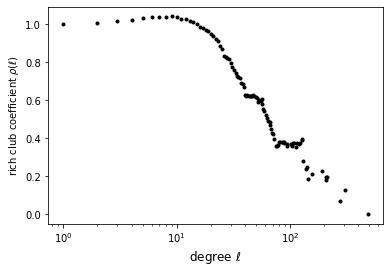

In [133]:
d = list(set(gh_ml.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_ml, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

c. Developer Web

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log




Degree correlation coefficient r: 420.3915627518108
Correlation exponent mu:2.900613617079679e-308


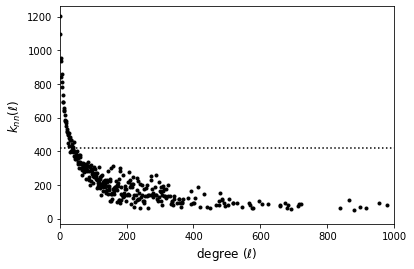

In [138]:
## degree correlation function
knn = deg_corr(gh_web)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_uncorr(gh_web)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
mu = corr_exp(gh_web)
print('\n')
print('Degree correlation coefficient r: ' + str(r))
print('Correlation exponent mu:' + str(mu))

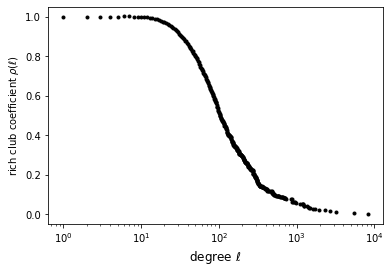

In [213]:
d = list(set(gh_web.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_web, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

# Problem 2

Running it on '*GitHub ML developers*' because of long runtime for long one

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36.436801463117256

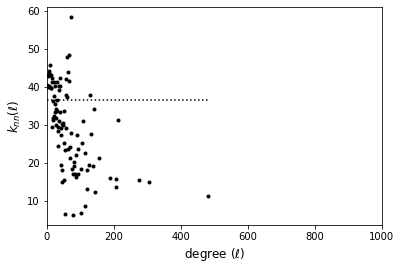

In [182]:
## degree correlation function
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(gh_ml)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
r

In [178]:
## Xulvi-Brunet and Sokolov algorithm
def switching(gh):
    g = gh.copy()
    g.es['touched'] = False
    ec = g.ecount()
    i = 0 
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        i+=1
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            np.random.shuffle(nodes)
            e1 = (nodes[0],nodes[3])
            e2 = (nodes[1],nodes[2])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        
        if sum(g.es['touched']) == g.ecount():
            break
    return g

In [179]:
gh_ml_rand = switching(gh_ml)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36.436801463117256

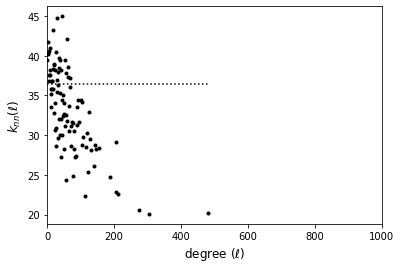

In [181]:
## degree correlation function
knn = deg_corr(gh_ml_rand)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(gh_ml_rand)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
r

For '*Web Developers*' graph the plot become more concentrated at certain space and slope is decreasing

# Problem 3

In [183]:
## Xulvi-Brunet and Sokolov algorithm
def cm_edge_switching(gh,c):
    g = gh.copy()
    g.es['touched'] = False
    ec = g.ecount()
    m = g.ecount()
    i = 0 
    iteration = c*m/2
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        i+=1
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            np.random.shuffle(nodes)
            e1 = (nodes[0],nodes[3])
            e2 = (nodes[1],nodes[2])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount() or i==iteration:
            break
    return g

c =  0.5

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


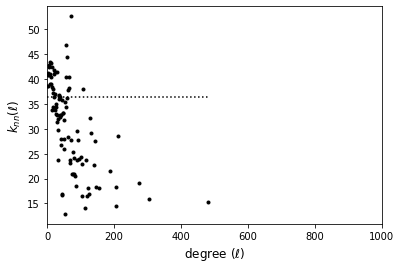

In [185]:
gh_ml_1 = cm_edge_switching(gh_ml,0.5)

## degree correlation function
knn = deg_corr(gh_ml_1)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(gh_ml_1)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
r
inter_ml_1 = ig.intersection([gh_ml,gh_ml_1])
count1 = inter_ml_1.ecount()

c = 1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


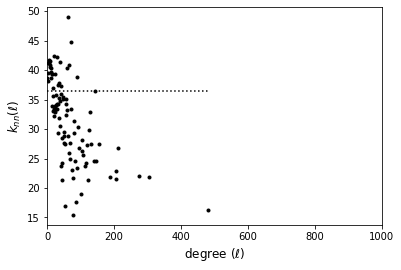

In [186]:
gh_ml_2 = cm_edge_switching(gh_ml,1)

## degree correlation function
knn = deg_corr(gh_ml_2)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(gh_ml_2)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
r
inter_ml_2 = ig.intersection([gh_ml,gh_ml_2])
count2 = inter_ml_2.ecount()

c = 2

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


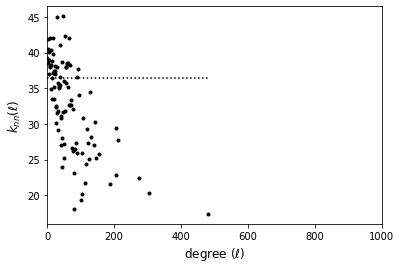

In [187]:
gh_ml_3 = cm_edge_switching(gh_ml,2)

## degree correlation function
knn = deg_corr(gh_ml_3)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(gh_ml_3)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')
r
inter_ml_3 = ig.intersection([gh_ml,gh_ml_3])
count3 = inter_ml_3.ecount()

In [212]:
print('Count of edges not shifted for c(0.5) : ' + str(count1))
print('Count of edges not shifted for c(1)   : ' + str(count2))
print('Count of edges not shifted for c(2)   : ' + str(count3))


Count of edges not shifted for c(0.5) : 14380
Count of edges not shifted for c(1)   : 10371
Count of edges not shifted for c(2)   : 5686


In [200]:
count1/gh_ml.ecount()

0.7305425726478358

In [201]:
count2/gh_ml.ecount()

0.5268746189798822

In [202]:
count3/gh_ml.ecount()

0.28886405202194676

# Problem 4

In [203]:
## Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g

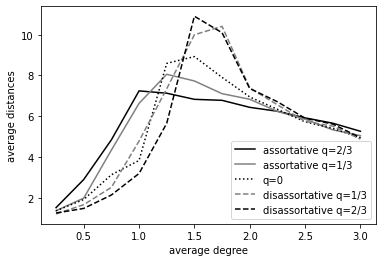

In [207]:

N = 2**8 ## 2**16 and 64 in book
Rep = 10
Q = [2/3,1/3,0,1/3,2/3]
A = [True,True,True,False,False]
x = np.arange(0.25,3.01,.25)
Y = []

for i in range(len(Q)):
    y = []
    for d in x:
        sz = 0
        for rep in range(Rep):
            g = XBS(n = N, d = d, q = Q[i] , assortative = A[i])
            sz +=  g.average_path_length()
        y.append(sz / Rep)
    Y.append(y)
    
clr = ['black','gray','black','gray','black']
typ = ['-','-',':','--','--']
lbl = ['assortative q=2/3','assortative q=1/3','q=0','disassortative q=1/3','disassortative q=2/3']
for i in range(len(Y)):
    plt.plot(x,Y[i],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel('average degree')
plt.ylabel('average distances')
plt.legend();
